# Discover CMS Datasets

```{admonition} Learning Objectives
- Learn how to search NASA earth data collections programatically in Python
- Learn how to restrict search results by space (study area) and time (project period).
- Plot data extent/boundaries in a map
- Download data files of interest.
````
In this tutorial, we will use `earthaccess` Python module to search for CMS datasets. 

In [1]:
import earthaccess
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
from shapely.geometry import box
from geodatasets import get_path
from collections import Counter
from wordcloud import WordCloud

## Search datasets by project
Let's use `earthaccess` module's [search_datasets API](https://earthaccess.readthedocs.io/en/latest/user-reference/api/api/#earthaccess.api.search_datasets) to search for datasets published under the CMS project. `search_datasets` will return a list DataCollection from [NASA's Common Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html).

In [2]:
datasets = earthaccess.search_datasets(project="CMS")
print(f"Total Datasets found: {len(datasets)}")

Total Datasets found: 168


First convert the above search results into a pandas dataframe. Converting to a pandas dataframe will streamline the query of the dataset search results.

In [3]:
def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    return df
    
df = convert_list_gdf(datasets)

## Spatial extent of datasets
NASA's CMR also stores the bounding coordinates of the data collections. Now, let's convert the pandas dataframe `df` we created above into a geopandas dataframe and plot the bounding box of each data collection.

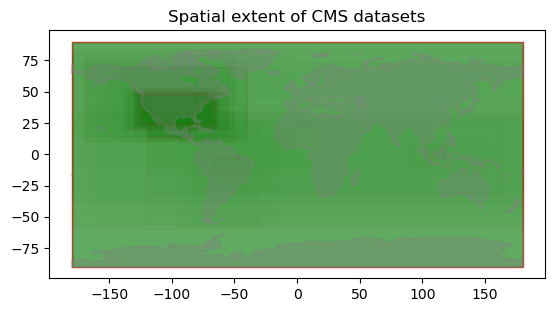

In [4]:
def convert_umm_bbox(b):
    """converts UMM bounding rectangles"""
    try:
        return box(b[0]['WestBoundingCoordinate'], 
              b[0]['SouthBoundingCoordinate'],
              b[0]['EastBoundingCoordinate'], 
              b[0]['NorthBoundingCoordinate'])
    except TypeError as e:
        return None
        
df['geometry'] = df['BoundingRectangles'].apply(convert_umm_bbox)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
world = gpd.read_file(get_path('naturalearth.land'))
ax = world.boundary.plot(alpha=0.3, facecolor='gray', edgecolor='gray')
gdf.plot(ax=ax, alpha=0.02, facecolor='g', edgecolor="r")
plt.title('Spatial extent of CMS datasets')
plt.show()

As we see above, there are more CMS datasets available over North America than other parts of the world. Some datasets have global coverage as well.

## Datasets by DAACs
There is a `provider-id` tag in the CMR metadata, which provides information on the DAAC responsible for archiving the datasets. CMR datasets are archived by the ORNL DAAC (`ORNL_CLOUD`) as well as by the GES DISC (`GES_DISC`). Let compute how many of the total datasets are archived by each DAACs.

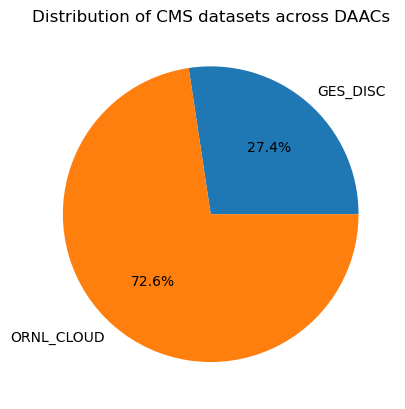

In [5]:
gdf.groupby('provider-id').size().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of CMS datasets across DAACs')
plt.ylabel('')
plt.show()

The ORNL DAAC counts for ~73% of the total CMS datasets publication.

## Datasets publication dates
NASA has published CMS datasets starting 2014. The following chart shows the number of CMS datasets published by year.

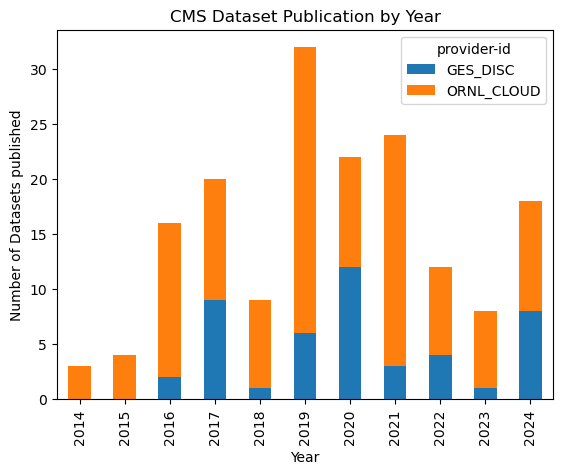

In [6]:
def get_releasedates(ddates):
    """get data release dates"""
    for d in ddates:
        try:
            reldate = pd.to_datetime(d['ReleaseDate']).year
        except KeyError as e:
            reldate = int(re.findall('(\d{4})', d['OtherCitationDetails'] )[0])
    return reldate
    
gdf['pub_date'] = gdf['CollectionCitations'].apply(get_releasedates)
gdf.groupby(['pub_date', 'provider-id']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Year')
plt.ylabel('Number of Datasets published')
plt.title('CMS Dataset Publication by Year')
plt.show()

As we see in the above chart, the CMS datasets is still being actively produced and published. 

## Datasets granule count
Let's plot some statistics of how many granules (or data files) are in each data collection.

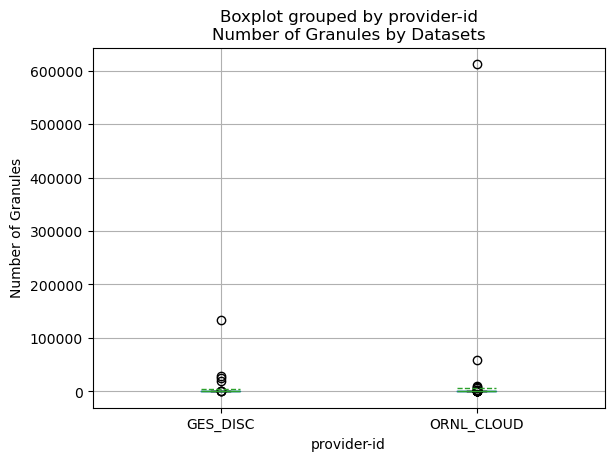

In [9]:
gdf.boxplot(column=['granule-count'], by='provider-id', meanline=True, showmeans=True)
plt.ylabel('Number of Granules')
plt.title('Number of Granules by Datasets')
plt.show()

As we see above, there are few data collections that have more than 100,000 granules. However, most collections have much fewer granules. 

Let's print the dataset with the largest number of granules.

In [27]:
# increase the max column width of pandas dataframe
pd.options.display.max_colwidth = 100
gdf.iloc[gdf['granule-count'].idxmax()][['EntryTitle', 'DOI', 'granule-count']]

EntryTitle       LiDAR Surveys over Selected Forest Research Sites, Brazilian Amazon, 2008-2018
DOI                                                                       10.3334/ORNLDAAC/1644
granule-count                                                                              3154
Name: 2, dtype: object

## Instrument keywords of the dataset

The CMR metadata of the data collection includes [GCMD keywords](https://www.earthdata.nasa.gov/learn/find-data/idn/gcmd-keywords), which provides information such as science variable, instruments and platforms of the data collections. Let's plot a word cloud of the GCMD Instrument keywords. This will give indication of what instruments were used to collect CMS datasets.

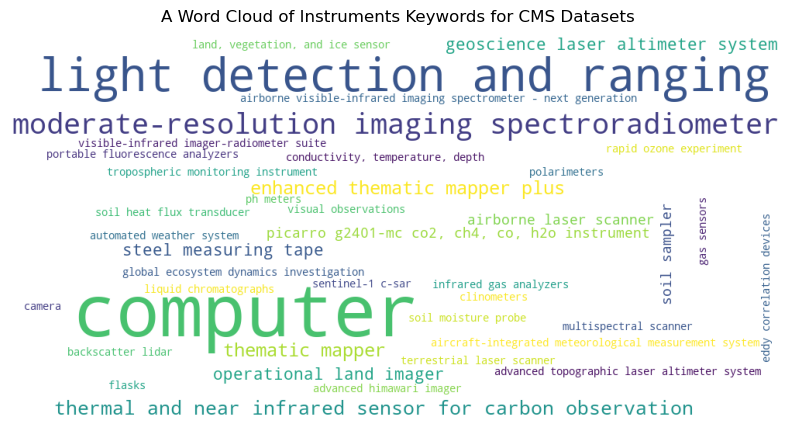

In [11]:
def get_keywords(keywords):
    """get data release dates"""
    keys = []
    if 'Instruments' in keywords[0].keys():
        for instr in keywords[0]['Instruments']:
            if 'LongName' in instr.keys():
                keys.append(instr['LongName'])
    return keys

gdf['gcmd_keys'] = gdf['Platforms'].apply(get_keywords)
gmcd_var = gdf['gcmd_keys'].explode().to_list()
gmcd_var =  [x.lower() for x in gmcd_var if x==x]
gmcd_var_dict=Counter(gmcd_var)
wordcloud = WordCloud(background_color='white', 
                      width = 1000, 
                      height = 500).generate_from_frequencies(gmcd_var_dict)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.title('A Word Cloud of Instruments Keywords for CMS Datasets')
plt.axis("off")
plt.show()

As we see in the above word cloud, lidar (light detection and ranging) is one of the most used instrument keyword for the CMS data collections. 

## Search by keyword

Lets search for all CMS datasets that has keyword "lidar" on their GCMD keyword metadata.

In [12]:
datasets = earthaccess.search_datasets(project="CMS", keyword="lidar")
print(f"Total CMS Datasets with lidar keyword: {len(datasets)}")

Total CMS Datasets with lidar keyword: 32


## Search by bounding box
We can also limit the search results for one area. Let's use the bounds of Brazil to only search for CMS datasets with "lidar" keyword.

In [13]:
# Brazil bounding box
bound = (-73.99, -33.77, -34.73, 5.25) 
datasets = earthaccess.search_datasets(project="CMS", keyword="lidar",
                                       bounding_box = bound)
print(f"Total CMS Datasets within Brazil: {len(datasets)}")

Total CMS Datasets within Brazil: 8


We can plot the bounding boxes of the CMS data collections over Brazil.

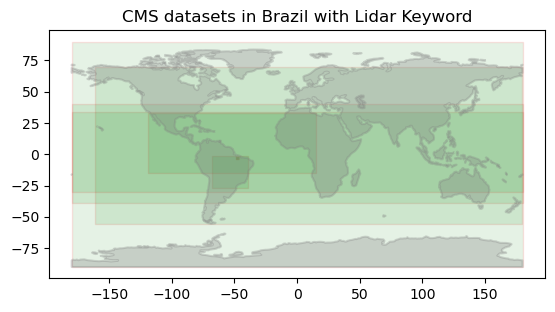

In [15]:
df = convert_list_gdf(datasets)
df['geometry'] = df['BoundingRectangles'].apply(convert_umm_bbox)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
world = gpd.read_file(get_path('naturalearth.land'))
ax = world.boundary.plot(alpha=0.3, facecolor='gray', edgecolor='gray')
gdf.plot(ax=ax, alpha=0.1, facecolor='g', edgecolor="r")
plt.title('CMS datasets in Brazil with Lidar Keyword')
plt.show()

We now print the data title, short name and DOI of the CMS datasets in Brazil with "lidar" keyword.

In [29]:
def hyperlink_doi(doi):
    """make doi link"""
    return f'<a target="_blank" href="https://doi.org/{doi}">{doi}</a>'

# print dataset title and doi    
df[['EntryTitle', 'DOI']].style.format({'DOI': hyperlink_doi})

,EntryTitle,DOI
0,"CMS: LiDAR Data for Forested Areas in Paragominas, Para, Brazil, 2012-2014",10.3334/ORNLDAAC/1302
1,"CMS: Global Mangrove Canopy Height Maps Derived from TanDEM-X, 2015",10.3334/ORNLDAAC/2251
2,"LiDAR Surveys over Selected Forest Research Sites, Brazilian Amazon, 2008-2018",10.3334/ORNLDAAC/1644
3,"LiDAR and PALSAR-Derived Forest Aboveground Biomass, Paragominas, Para, Brazil, 2012",10.3334/ORNLDAAC/1648
4,"CMS: GLAS LiDAR-derived Global Estimates of Forest Canopy Height, 2004-2008",10.3334/ORNLDAAC/1271
5,"Global Forest Aboveground Carbon Stocks and Fluxes from GEDI and ICESat-2, 2018-2021",10.3334/ORNLDAAC/2180
6,Pantropical Forest Height and Biomass from GEDI and TanDEM-X Data Fusion,10.3334/ORNLDAAC/2298
7,"Aboveground Biomass Change for Amazon Basin, Mexico, and Pantropical Belt, 2003-2016",10.3334/ORNLDAAC/1824


In the next tutorial, we will download the lidar dataset ["LiDAR Surveys over Selected Forest Research Sites, Brazilian Amazon, 2008-2018"](https://doi.org/10.3334/ORNLDAAC/1644) and look into details.